In [1]:
import Neural_Network_Tools.tools as nnt
(train_data, train_labels),(test_data, test_labels) = nnt.prepare_train_test_dataset()

In [2]:
import time 
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import os
from keras.models import load_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

NUM_OF_CLASSES = 3

def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def weight_clustering(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):

  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  clustering_params = {
    'number_of_clusters': 16,
    'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
  }

  # Cluster a whole model
  clustered_model = cluster_weights(new_model, **clustering_params)

  # Use smaller learning rate for fine-tuning clustered model
  opt = Adam(learning_rate=1e-5)

  clustered_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy'])

  # clustered_model.summary()

  # Fine-tune model
  train_start_time = time.time()
  clustered_model_history = clustered_model.fit(
    train_data,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1)
  
  train_stop_time = time.time() - train_start_time
  print("Training time: ", train_stop_time)

  nnt.plot_history(clustered_model_history, epochs, os.path.join(store_path,"history_clustered_fnn_model"))
  
  test_start_time = time.time()
  _, clustered_model_accuracy = clustered_model.evaluate(test_data, test_labels, verbose=0)
  test_stop_time = time.time() - test_start_time
  print("Test time: ", test_stop_time)
  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Clustered test accuracy:', clustered_model_accuracy)

  final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

  clustered_keras_file = os.path.join(store_path, "clustered_model.h5")
  print('Saving clustered model to: ', clustered_keras_file)
  tf.keras.models.save_model(final_model, clustered_keras_file, include_optimizer=False)

  clustered_tflite_file = os.path.join(store_path, "clustered_tflite_model.tflite")
  converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
  tflite_clustered_model = converter.convert()
  with open(clustered_tflite_file, 'wb') as f:
    f.write(tflite_clustered_model)
  print('Saved clustered TFLite model to:', clustered_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(keras_file)))
  print("Size of gzipped clustered Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(clustered_keras_file)))
  print("Size of gzipped clustered TFlite model: %.2f bytes" % (nnt.get_gzipped_model_size(clustered_tflite_file)))
  return new_model, final_model

Original model test accuracy: 0.9941359758377075
Saved baseline model to: Clustering\baseline_model.h5
Epoch 1/10
542/542 [==============================] - 5s 7ms/step - loss: 1.2328 - accuracy: 0.8486 - val_loss: 0.8062 - val_accuracy: 0.8735
Epoch 2/10
542/542 [==============================] - 3s 6ms/step - loss: 0.5552 - accuracy: 0.8957 - val_loss: 0.1893 - val_accuracy: 0.9329
Epoch 3/10
542/542 [==============================] - 3s 6ms/step - loss: 0.1017 - accuracy: 0.9683 - val_loss: 0.0703 - val_accuracy: 0.9800
Epoch 4/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0594 - accuracy: 0.9814 - val_loss: 0.0487 - val_accuracy: 0.9859
Epoch 5/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0394 - accuracy: 0.9865 - val_loss: 0.0290 - val_accuracy: 0.9917
Epoch 6/10
542/542 [==============================] - 3s 6ms/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0233 - val_accuracy: 0.9935
Epoch 7/10
542/542 [=========================

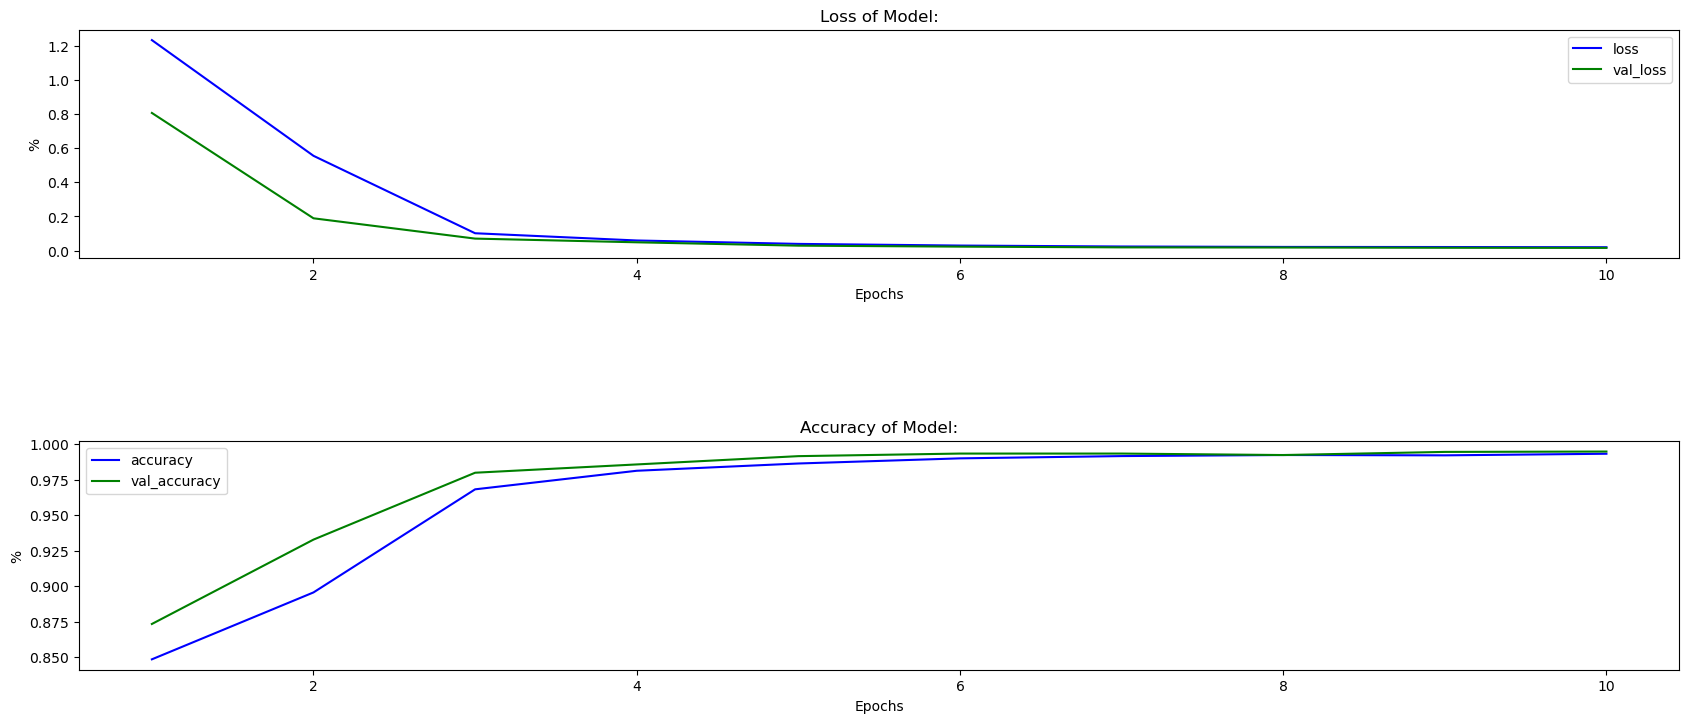

Test time:  2.6347365379333496
Baseline test accuracy: 0.9941359758377075
Clustered test accuracy: 0.9938246011734009
Saving clustered model to:  Clustering\clustered_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmp5hxcoevu\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmp5hxcoevu\assets


Saved clustered TFLite model to: Clustering\clustered_tflite_model.tflite
Size of gzipped baseline Keras model: 290008.00 bytes
Size of gzipped clustered Keras model: 53848.00 bytes
Size of gzipped clustered TFlite model: 52780.00 bytes


In [3]:
keras_model, final_model = weight_clustering("fnn_model.h5", train_data, train_labels, test_data, test_labels, 128, 10, "Clustering")

# Clustering & Post-training Quantization

In [4]:

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

quantized_and_clustered_tflite_file = os.path.join("Clustering", "quantized_clustered_tflite_model.tflite")

with open(quantized_and_clustered_tflite_file, 'wb') as f:
  f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
# print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_model)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (nnt.get_gzipped_model_size(quantized_and_clustered_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmp4oo30nr5\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmp4oo30nr5\assets


Saved quantized and clustered TFLite model to: Clustering\quantized_clustered_tflite_model.tflite
Size of gzipped clustered and quantized TFlite model: 41817.00 bytes


In [5]:
import numpy as np

def evaluate_model(interpreter, test_data, test_labels):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # test_labels = np.argmax(test_labels, axis=1)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  test_start_time = time.time()
  for i, test_sample in enumerate(test_data):
    # if i % 1000 == 0:
    #   print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_sample)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  test_stop_time = time.time() - test_start_time
  print(test_stop_time)
  return accuracy

In [6]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_data, test_labels)

print('Clustered and quantized TFLite test_accuracy:', test_accuracy)




0.6431591510772705
Clustered and quantized TFLite test_accuracy: 0.9927348209652309
